In [1]:
seed_value= 0

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import pickle

#Scikit-Learn Importing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.svm import SVR

#Import PyWavelets for WaveSmoothing
import pywt
import mad
from statsmodels import robust

#Import Keras
import keras
from keras.layers import Input, Dense, BatchNormalization, Dropout, LSTM, RepeatVector, TimeDistributed
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, Adadelta
from tqdm import tqdm
from keras.callbacks import History 
history = History()
from keras import backend as K

#Import Gridsearch
from hypopt import GridSearch

#Import Capstone Functions
from Capstone_Functions import *
cf = CapstoneFunctions()

In [3]:
Monthly = pd.read_pickle('data/Monthly.pkl')
Monthly2 = pd.read_pickle('data/MonthlyReturns.pkl')

In [4]:
WOMonthly = Monthly.iloc[:,14:15].copy()
WOMonthly.head()

WOMonthly
date                 
1990-12-03   0.052244
1991-01-01   0.011277
1991-02-01   0.015239
1991-03-01   0.096461
1991-04-01   0.026566

In [5]:
FIPMonthly = Monthly2.iloc[:,16:17].copy()
FIPMonthly.head()

FIPMonthly
date                  
1990-12-03    0.034620
1991-01-01    0.022021
1991-02-01    0.013218
1991-03-01    0.089188
1991-04-01    0.031861

In [6]:
#Create Train_Test_Split for High and Low Momentum returns with a 60 Month Lookback
WOXdata, WOYdata, WOXtrain, WOYtrain, WOXtest, WOYtest, WOPredictedX, WOForecastX, WOX, WOY = \
cf.Train_Test_Split(WOMonthly, 0, 100, 12, scaler = False)

FIPXdata, FIPYdata, FIPXtrain, FIPYtrain, FIPXtest, FIPYtest, FIPPredictedX, FIPForecastX, FIPX, FIPY = \
cf.Train_Test_Split(FIPMonthly, 0, 100, 12, scaler = False)

In [7]:
def waveletSmooth( x, wavelet="haar", level=2, DecLvl=2):
    # calculate the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=DecLvl )
    # calculate a threshold
    sigma = robust.mad(coeff[-level])
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode="soft" ) for i in coeff[1:] )
    # reconstruct the signal using the thresholded coefficients
    y = pywt.waverec( coeff, wavelet, mode="per" )
    return y

In [8]:
wav_wo = waveletSmooth(WOMonthly.iloc[:,0])
wav_wo = wav_wo.reshape(len(wav_wo),1)

wav_fip = waveletSmooth(FIPMonthly.iloc[:,0])
wav_fip = wav_fip.reshape(len(wav_fip),1)

In [9]:
    def Train_Test_Split2(Data1, Hi_or_Lo, Window, Lookback): 

        """ 
        Import Monthly data with Date as Index. Select which portfolio to train test split. Set number of
        lookback months and whether to use MinMaxScaler.

        Example:
        HiXdata, HiYdata, HiXtrain, HiYtrain, HiXtest, HiYtest, HiPredictedX, HiForecastX, HiX, HiY = \
        Train_Test_Split(Monthly, 'Hi', 60, 12, scaler = False)

        """ 


        #If High or Low Momentum Portfolio
        if Hi_or_Lo == 'Hi':
            Port = 0
        else:
            Port =  0

        TrainSplit = int(Window*0.9)
        TestSplit = int(Window*0.1)

        #Iterate Through Data and Creat Numpy arrays with 12 Months of \ 
        #lagged data for X and 13th Month for Y
        tmpX=[]
        tmpY=[]
        for A in range(len(Data1)-Lookback):
            tmp=Data1[A:(A + Lookback),Port]
            tmpX.append(tmp)
            tmpY.append(Data1[(A + Lookback),Port])
        Xdata = np.array(tmpX)
        Ydata = np.array(tmpY)

        tmpForeX=[]
        for A in range(len(Data1)-Lookback):
            tmpFore=Data1[A+1:(A+1 + Lookback),Port]
            tmpForeX.append(tmpFore)
        XdataFore = np.array(tmpForeX)

        Ydata = Ydata.reshape(len(Ydata),1)

        Shape = int(Xdata.shape[0])
        Shape2 = int(XdataFore.shape[0])


        #Create Empty Numpy Arrays
        Xtrain=np.ones(shape=(Shape-Window,TrainSplit,12))
        Ytrain=np.ones(shape=(Shape-Window,TrainSplit,1))
        Xtest=np.ones(shape=(Shape-Window,TestSplit,Lookback))
        Ytest=np.ones(shape=(Shape-Window,TestSplit,1))
        PredictedX=np.ones(shape=(Shape-Window,1,Lookback))
        ForecastX=np.ones(shape=(Shape2-Window,1,Lookback))
        X = np.ones(shape=(Shape-Window,Window,Lookback))
        Y = np.ones(shape=(Shape-Window,Window,1))

        #Fill Numpy Arrays with data
        for B in range(Shape-Window):
            Xtrain[B,:,:] = Xdata[B:B+TrainSplit,:]
            Ytrain[B,:,:] = Ydata[B:B+TrainSplit]
            Xtest[B,:,:] = Xdata[B+TrainSplit:B+Window,:]
            Ytest[B,:,:] = Ydata[B+TrainSplit:B+Window]
            PredictedX[B,:,:] = Xdata[B+Window,:]
            ForecastX[B,:,:] = XdataFore[B+Window,:]
            X[B,:,:] = Xdata[B:B+Window,:]
            Y[B,:,:] = Ydata[B:B+Window]

        return Xdata, Ydata, Xtrain, Ytrain, Xtest, Ytest, PredictedX, ForecastX, X, Y

In [10]:
#Create Train_Test_Split for High and Low Momentum returns with a 100 Month Lookback
W_WO_Xdata, W_WO_Ydata, W_WO_Xtrain, W_WO_Ytrain, W_WO_Xtest, W_WO_Ytest, W_WO_ForecastX, \
W_WO_ForecastX, W_WO_X, W_WO_Y = \
Train_Test_Split2(wav_wo, 'Hi', 100, 12)

#Create Train_Test_Split for High and Low Momentum returns with a 100 Month Lookback
W_FIP_Xdata, W_FIP_Ydata, W_FIP_Xtrain, W_FIP_Ytrain, W_FIP_Xtest, W_FIP_Ytest, W_FIP_ForecastX,\
W_FIP_ForecastX, W_FIP_X, W_FIP_Y = \
Train_Test_Split2(wav_fip, 'Hi', 100, 12)

# LSTM

In [11]:
epochs = 200
batch = 100

In [12]:
def LSTM_Reshape(LSTM_Shape):
    LSTM_Shape = LSTM_Shape.reshape((LSTM_Shape.shape[0],LSTM_Shape.shape[1],1))
    return LSTM_Shape

def LSTM_RNN(Xtrain, Ytrain, Xtest, Ytest, Xtrue):
    keras.backend.clear_session()
    LSTM_ = Sequential()
    LSTM_.add(LSTM(8, input_shape = (12,1), return_sequences = True))
    LSTM_.add(Dropout(0.2))
    LSTM_.add(LSTM(8, return_sequences = True))
    LSTM_.add(Dropout(0.2))
    LSTM_.add(LSTM(8, return_sequences = False))
    LSTM_.add(Dropout(0.2))
    LSTM_.add(Dense(1, activation = 'linear'))
    LSTM_.compile(loss='mse', optimizer = Adam(lr = 0.05))
    LSTM_.fit(Xtrain, Ytrain, batch_size = batch, epochs = epochs,
       validation_data = (Xtest, Ytest), shuffle = False, verbose = 0)
    Prediction_ = LSTM_.predict(Xtrue)
    history = LSTM_.fit(Xtrain, Ytrain, batch_size = batch, epochs = epochs,
       validation_data = (Xtest, Ytest), shuffle = False, verbose = 0)
    Prediction_ = LSTM_.predict(Xtrue)
    
    print(history.history.keys())
   
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'test'], loc='upper left')  
    plt.show()
    
    return (Prediction_)

def predictLSTM(Xtrain, Ytrain, Xtest, Ytest, XFore):
    Final_Prediction = np.zeros(shape=(244,1))
    for i in range(Final_Prediction.shape[0]):
        Xtrain_Reshape = LSTM_Reshape(Xtrain[i])
        Xtest_Reshape = LSTM_Reshape(Xtest[i])
        XFore_Reshape = LSTM_Reshape(XFore[i])
        Final_Prediction[i] = LSTM_RNN(Xtrain_Reshape, Ytrain[i], Xtest_Reshape, Ytest[i], XFore_Reshape)
        print('Prediction',i+1,'of',244)
    return Final_Prediction

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
dict_keys(['val_loss', 'loss'])


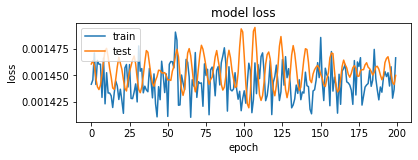

Prediction 1 of 244
dict_keys(['val_loss', 'loss'])


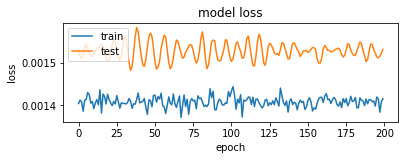

Prediction 2 of 244
dict_keys(['val_loss', 'loss'])


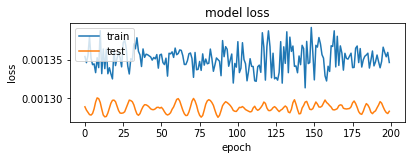

Prediction 3 of 244
dict_keys(['val_loss', 'loss'])


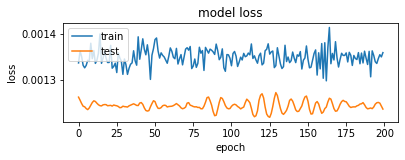

Prediction 4 of 244
dict_keys(['val_loss', 'loss'])


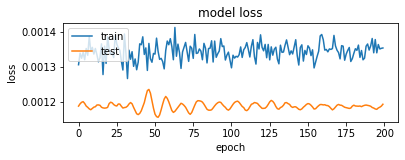

Prediction 5 of 244
dict_keys(['val_loss', 'loss'])


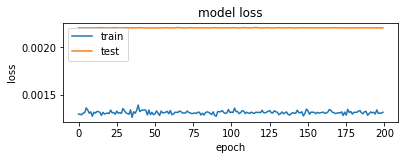

Prediction 6 of 244
dict_keys(['val_loss', 'loss'])


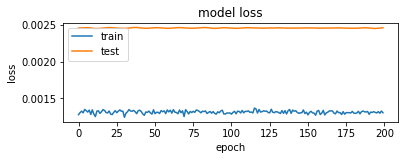

Prediction 7 of 244
dict_keys(['val_loss', 'loss'])


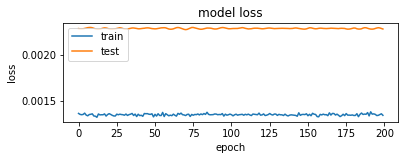

Prediction 8 of 244
dict_keys(['val_loss', 'loss'])


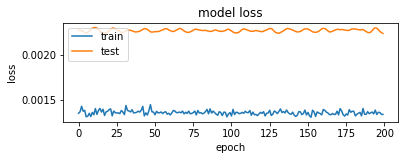

Prediction 9 of 244
dict_keys(['val_loss', 'loss'])


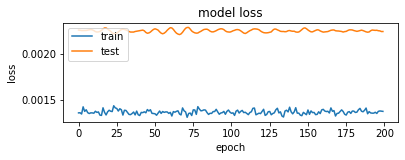

Prediction 10 of 244
dict_keys(['val_loss', 'loss'])


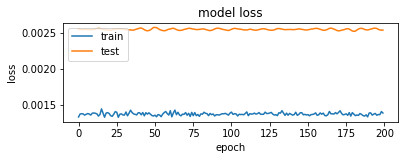

Prediction 11 of 244
dict_keys(['val_loss', 'loss'])


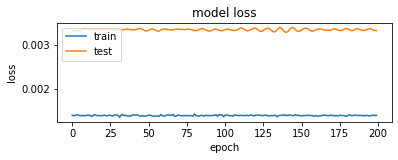

Prediction 12 of 244
dict_keys(['val_loss', 'loss'])


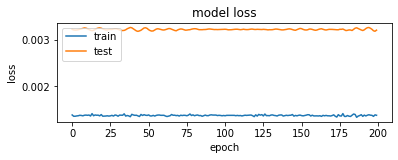

Prediction 13 of 244
dict_keys(['val_loss', 'loss'])


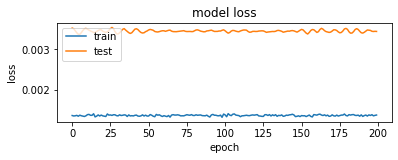

Prediction 14 of 244
dict_keys(['val_loss', 'loss'])


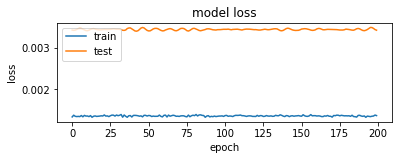

Prediction 15 of 244
dict_keys(['val_loss', 'loss'])


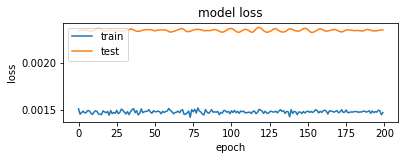

Prediction 16 of 244
dict_keys(['val_loss', 'loss'])


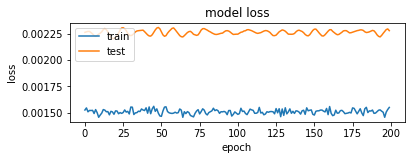

Prediction 17 of 244
dict_keys(['val_loss', 'loss'])


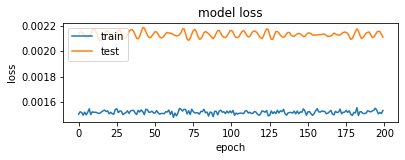

Prediction 18 of 244
dict_keys(['val_loss', 'loss'])


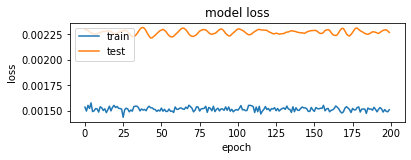

Prediction 19 of 244
dict_keys(['val_loss', 'loss'])


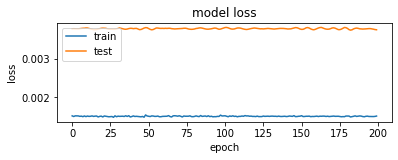

Prediction 20 of 244
dict_keys(['val_loss', 'loss'])


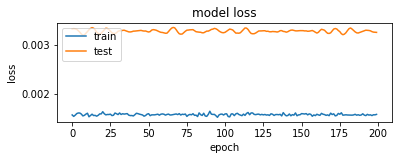

Prediction 21 of 244
dict_keys(['val_loss', 'loss'])


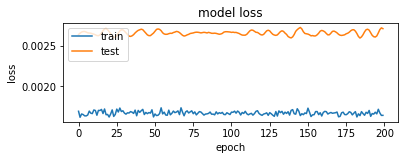

Prediction 22 of 244
dict_keys(['val_loss', 'loss'])


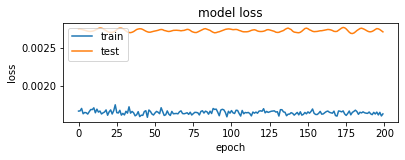

Prediction 23 of 244
dict_keys(['val_loss', 'loss'])


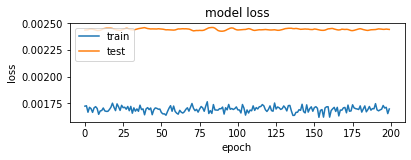

Prediction 24 of 244
dict_keys(['val_loss', 'loss'])


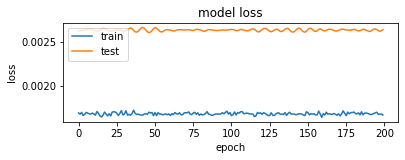

Prediction 25 of 244
dict_keys(['val_loss', 'loss'])


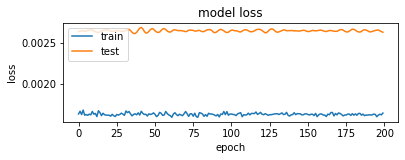

Prediction 26 of 244
dict_keys(['val_loss', 'loss'])


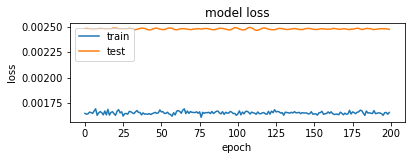

Prediction 27 of 244
dict_keys(['val_loss', 'loss'])


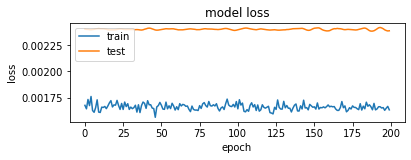

Prediction 28 of 244
dict_keys(['val_loss', 'loss'])


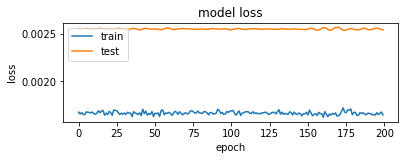

Prediction 29 of 244
dict_keys(['val_loss', 'loss'])


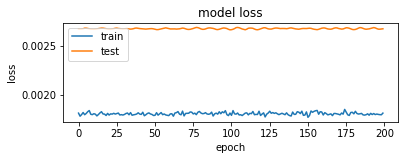

Prediction 30 of 244
dict_keys(['val_loss', 'loss'])


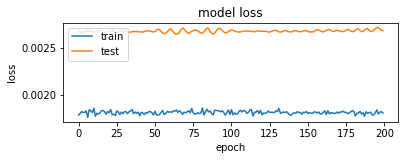

Prediction 31 of 244
dict_keys(['val_loss', 'loss'])


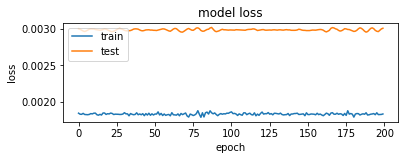

Prediction 32 of 244
dict_keys(['val_loss', 'loss'])


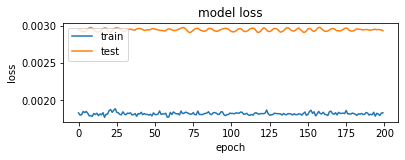

Prediction 33 of 244
dict_keys(['val_loss', 'loss'])


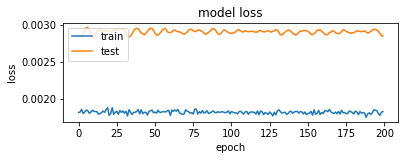

Prediction 34 of 244
dict_keys(['val_loss', 'loss'])


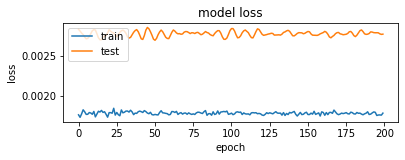

Prediction 35 of 244
dict_keys(['val_loss', 'loss'])


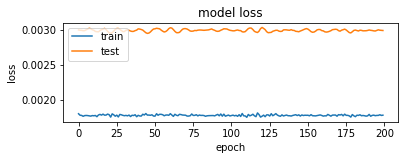

Prediction 36 of 244
dict_keys(['val_loss', 'loss'])


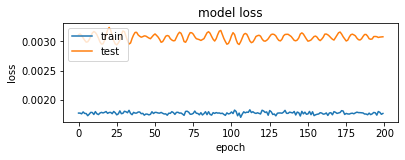

Prediction 37 of 244
dict_keys(['val_loss', 'loss'])


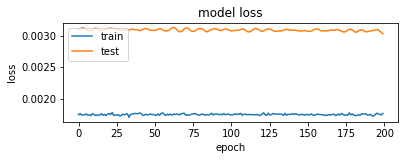

Prediction 38 of 244
dict_keys(['val_loss', 'loss'])


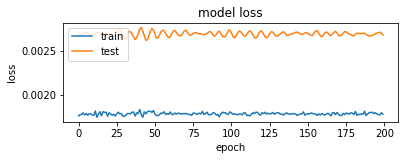

Prediction 39 of 244
dict_keys(['val_loss', 'loss'])


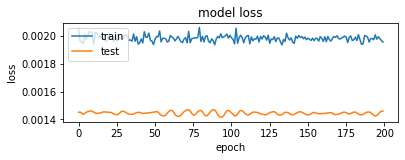

Prediction 40 of 244
dict_keys(['val_loss', 'loss'])


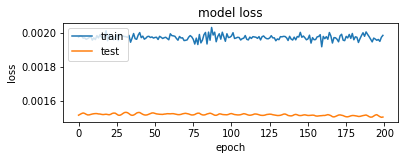

Prediction 41 of 244
dict_keys(['val_loss', 'loss'])


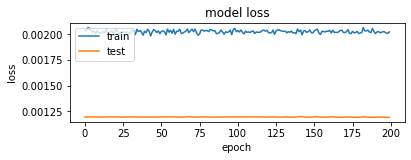

Prediction 42 of 244
dict_keys(['val_loss', 'loss'])


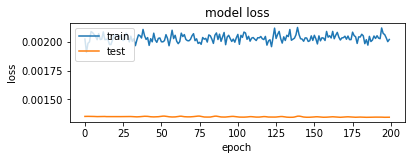

Prediction 43 of 244
dict_keys(['val_loss', 'loss'])


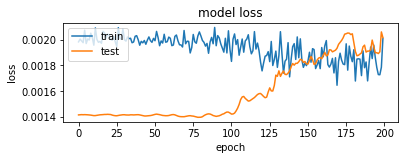

Prediction 44 of 244
dict_keys(['val_loss', 'loss'])


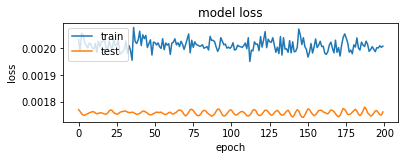

Prediction 45 of 244
dict_keys(['val_loss', 'loss'])


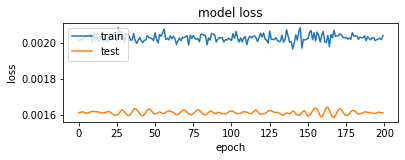

Prediction 46 of 244
dict_keys(['val_loss', 'loss'])


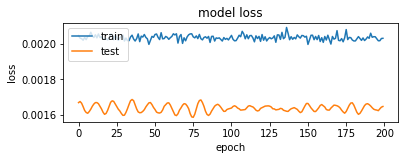

Prediction 47 of 244
dict_keys(['val_loss', 'loss'])


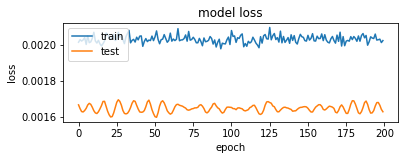

Prediction 48 of 244
dict_keys(['val_loss', 'loss'])


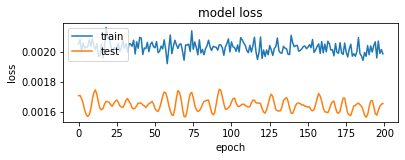

Prediction 49 of 244
dict_keys(['val_loss', 'loss'])


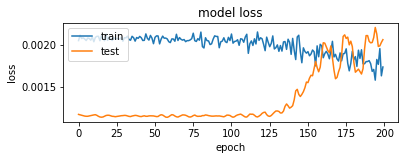

Prediction 50 of 244
dict_keys(['val_loss', 'loss'])


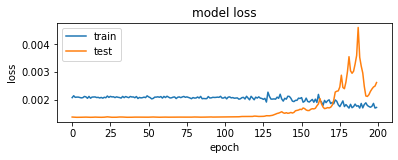

Prediction 51 of 244
dict_keys(['val_loss', 'loss'])


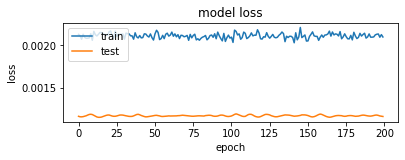

Prediction 52 of 244
dict_keys(['val_loss', 'loss'])


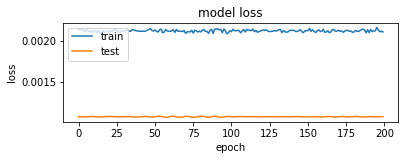

Prediction 53 of 244
dict_keys(['val_loss', 'loss'])


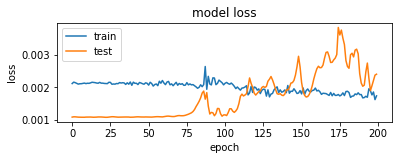

Prediction 54 of 244
dict_keys(['val_loss', 'loss'])


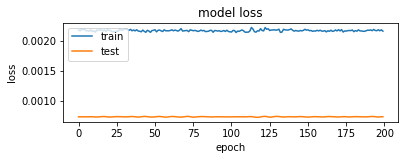

Prediction 55 of 244
dict_keys(['val_loss', 'loss'])


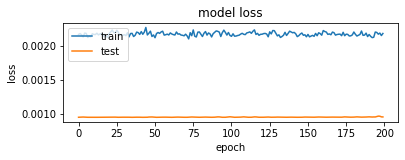

Prediction 56 of 244
dict_keys(['val_loss', 'loss'])


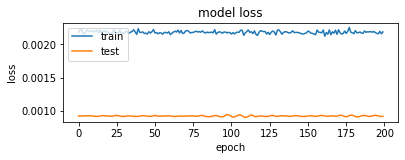

Prediction 57 of 244
dict_keys(['val_loss', 'loss'])


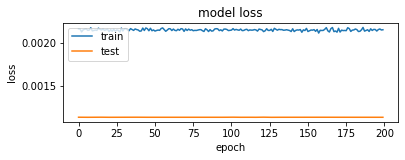

Prediction 58 of 244
dict_keys(['val_loss', 'loss'])


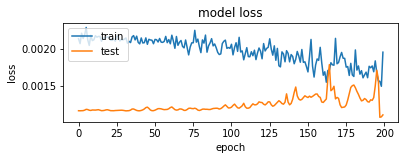

Prediction 59 of 244
dict_keys(['val_loss', 'loss'])


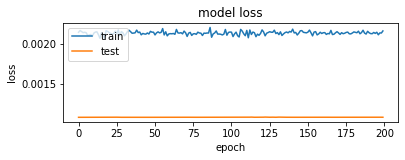

Prediction 60 of 244
dict_keys(['val_loss', 'loss'])


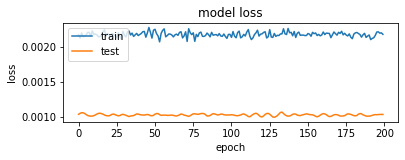

Prediction 61 of 244
dict_keys(['val_loss', 'loss'])


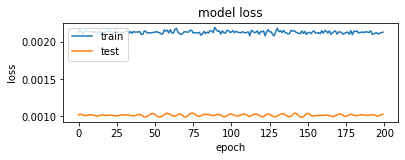

Prediction 62 of 244
dict_keys(['val_loss', 'loss'])


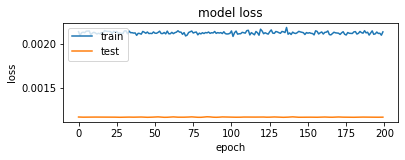

Prediction 63 of 244
dict_keys(['val_loss', 'loss'])


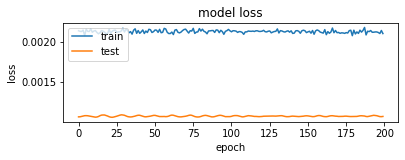

Prediction 64 of 244
dict_keys(['val_loss', 'loss'])


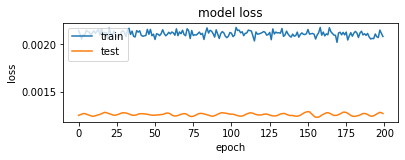

Prediction 65 of 244
dict_keys(['val_loss', 'loss'])


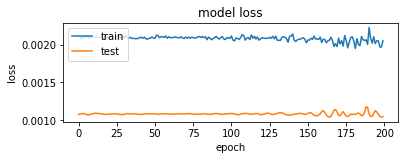

Prediction 66 of 244
dict_keys(['val_loss', 'loss'])


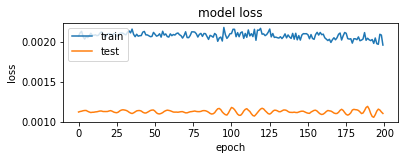

Prediction 67 of 244
dict_keys(['val_loss', 'loss'])


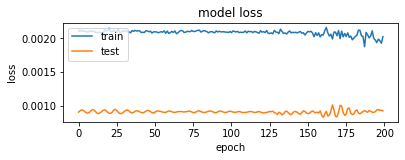

Prediction 68 of 244
dict_keys(['val_loss', 'loss'])


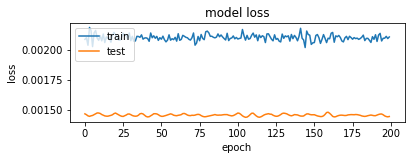

Prediction 69 of 244
dict_keys(['val_loss', 'loss'])


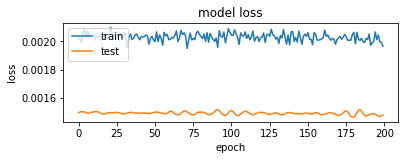

Prediction 70 of 244
dict_keys(['val_loss', 'loss'])


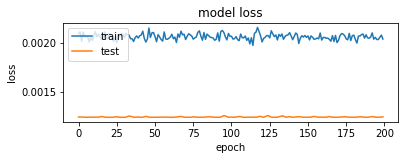

Prediction 71 of 244
dict_keys(['val_loss', 'loss'])


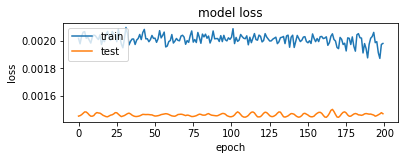

Prediction 72 of 244
dict_keys(['val_loss', 'loss'])


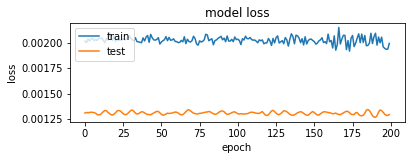

Prediction 73 of 244
dict_keys(['val_loss', 'loss'])


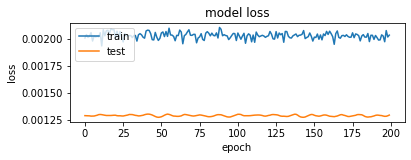

Prediction 74 of 244
dict_keys(['val_loss', 'loss'])


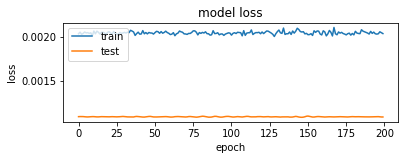

Prediction 75 of 244
dict_keys(['val_loss', 'loss'])


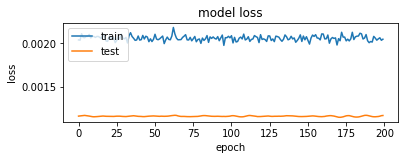

Prediction 76 of 244
dict_keys(['val_loss', 'loss'])


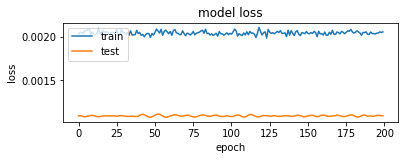

Prediction 77 of 244
dict_keys(['val_loss', 'loss'])


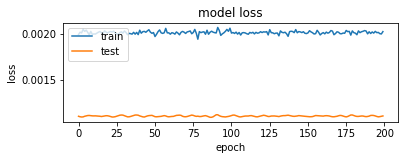

Prediction 78 of 244
dict_keys(['val_loss', 'loss'])


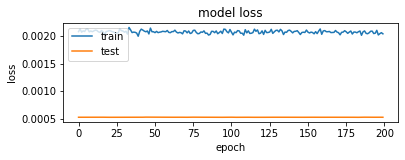

Prediction 79 of 244
dict_keys(['val_loss', 'loss'])


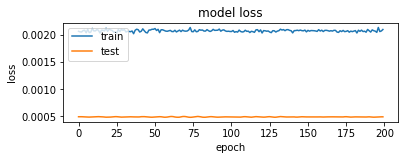

Prediction 80 of 244
dict_keys(['val_loss', 'loss'])


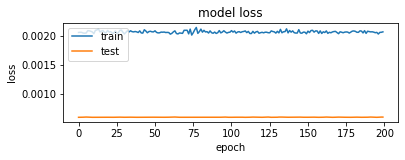

Prediction 81 of 244
dict_keys(['val_loss', 'loss'])


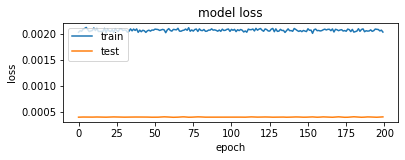

Prediction 82 of 244
dict_keys(['val_loss', 'loss'])


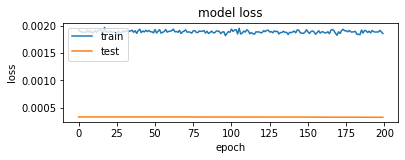

Prediction 83 of 244
dict_keys(['val_loss', 'loss'])


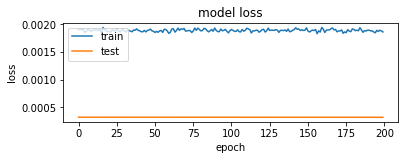

Prediction 84 of 244
dict_keys(['val_loss', 'loss'])


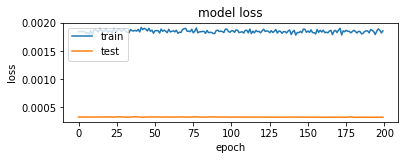

Prediction 85 of 244
dict_keys(['val_loss', 'loss'])


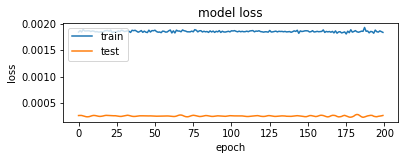

Prediction 86 of 244
dict_keys(['val_loss', 'loss'])


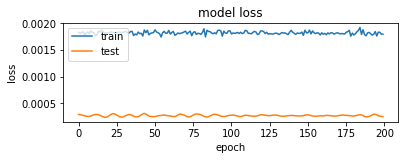

Prediction 87 of 244
dict_keys(['val_loss', 'loss'])


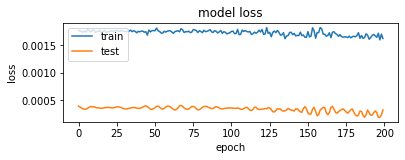

Prediction 88 of 244
dict_keys(['val_loss', 'loss'])


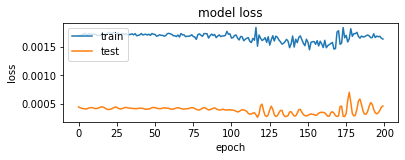

Prediction 89 of 244
dict_keys(['val_loss', 'loss'])


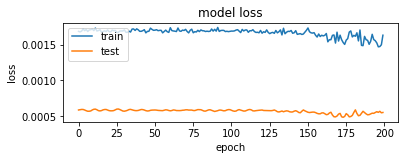

Prediction 90 of 244
dict_keys(['val_loss', 'loss'])


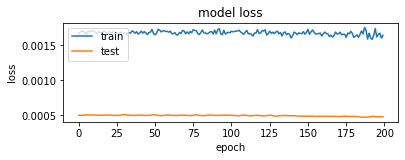

Prediction 91 of 244
dict_keys(['val_loss', 'loss'])


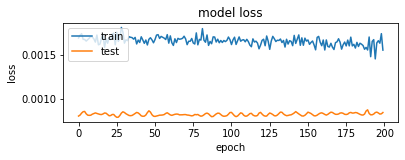

Prediction 92 of 244
dict_keys(['val_loss', 'loss'])


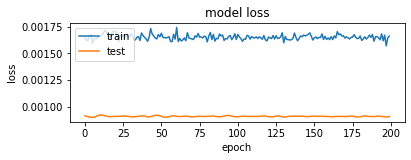

Prediction 93 of 244
dict_keys(['val_loss', 'loss'])


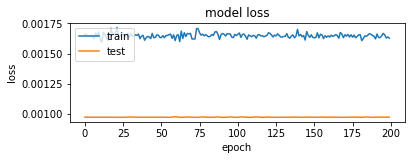

Prediction 94 of 244
dict_keys(['val_loss', 'loss'])


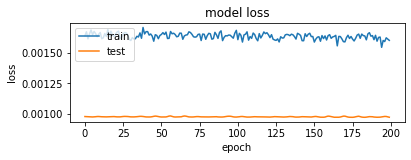

Prediction 95 of 244
dict_keys(['val_loss', 'loss'])


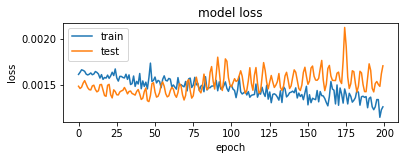

Prediction 96 of 244
dict_keys(['val_loss', 'loss'])


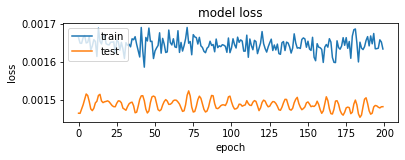

Prediction 97 of 244
dict_keys(['val_loss', 'loss'])


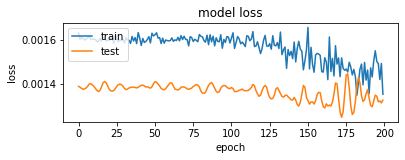

Prediction 98 of 244
dict_keys(['val_loss', 'loss'])


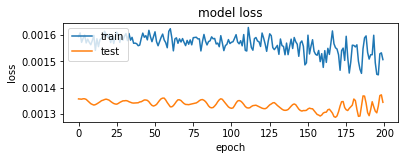

Prediction 99 of 244
dict_keys(['val_loss', 'loss'])


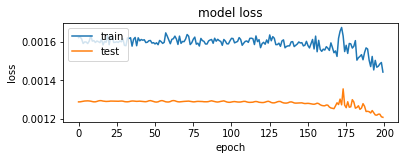

Prediction 100 of 244
dict_keys(['val_loss', 'loss'])


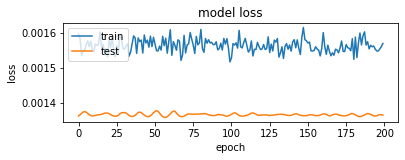

Prediction 101 of 244
dict_keys(['val_loss', 'loss'])


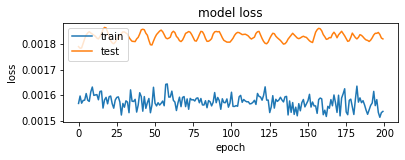

Prediction 102 of 244
dict_keys(['val_loss', 'loss'])


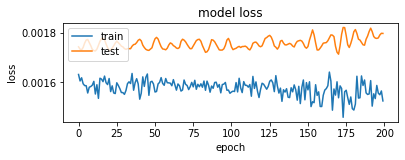

Prediction 103 of 244
dict_keys(['val_loss', 'loss'])


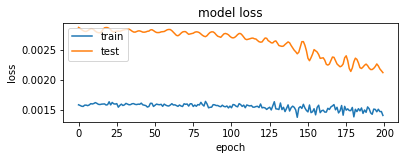

Prediction 104 of 244
dict_keys(['val_loss', 'loss'])


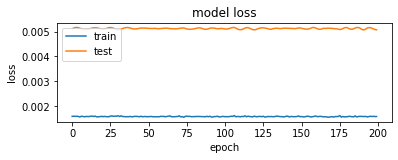

Prediction 105 of 244
dict_keys(['val_loss', 'loss'])


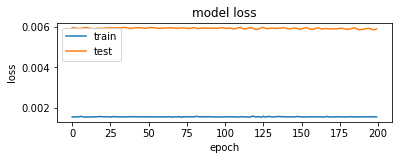

Prediction 106 of 244
dict_keys(['val_loss', 'loss'])


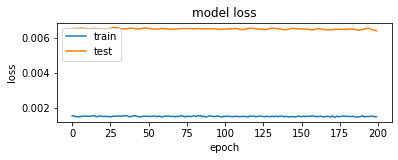

Prediction 107 of 244
dict_keys(['val_loss', 'loss'])


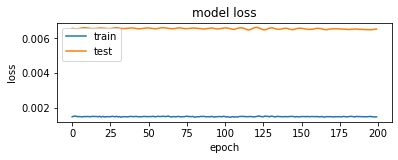

Prediction 108 of 244
dict_keys(['val_loss', 'loss'])


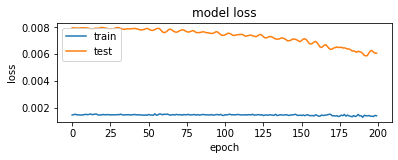

Prediction 109 of 244
dict_keys(['val_loss', 'loss'])


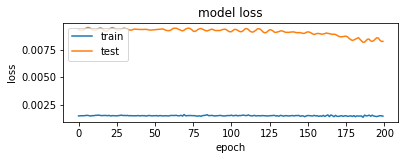

Prediction 110 of 244
dict_keys(['val_loss', 'loss'])


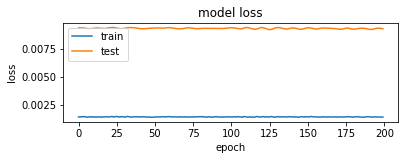

Prediction 111 of 244
dict_keys(['val_loss', 'loss'])


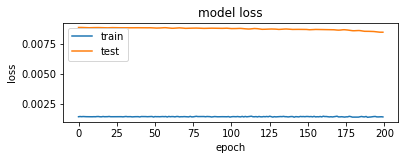

Prediction 112 of 244
dict_keys(['val_loss', 'loss'])


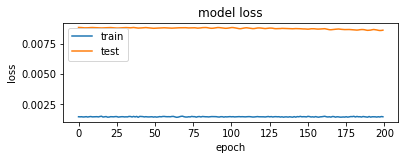

Prediction 113 of 244
dict_keys(['val_loss', 'loss'])


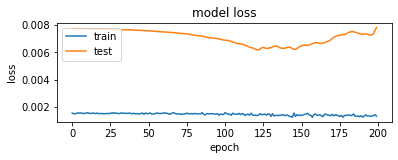

Prediction 114 of 244
dict_keys(['val_loss', 'loss'])


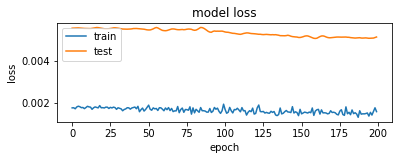

Prediction 115 of 244
dict_keys(['val_loss', 'loss'])


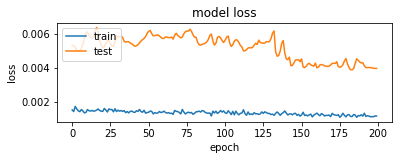

Prediction 116 of 244
dict_keys(['val_loss', 'loss'])


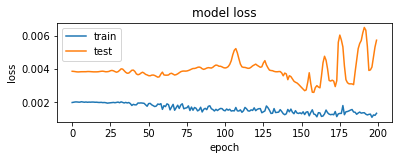

Prediction 117 of 244
dict_keys(['val_loss', 'loss'])


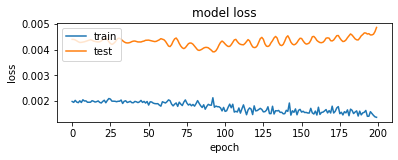

Prediction 118 of 244
dict_keys(['val_loss', 'loss'])


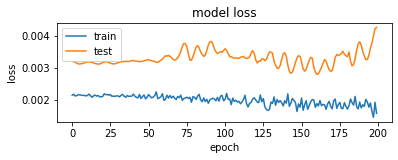

Prediction 119 of 244
dict_keys(['val_loss', 'loss'])


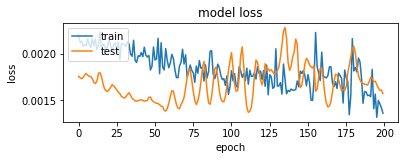

Prediction 120 of 244
dict_keys(['val_loss', 'loss'])


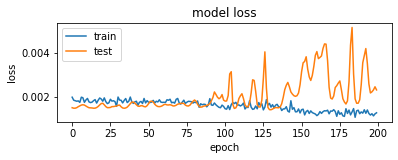

Prediction 121 of 244
dict_keys(['val_loss', 'loss'])


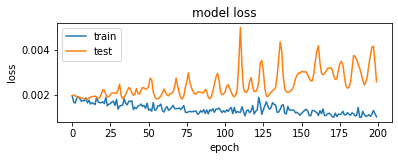

Prediction 122 of 244
dict_keys(['val_loss', 'loss'])


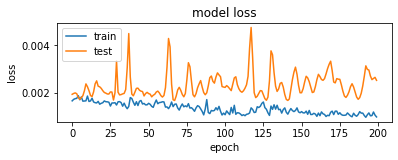

Prediction 123 of 244
dict_keys(['val_loss', 'loss'])


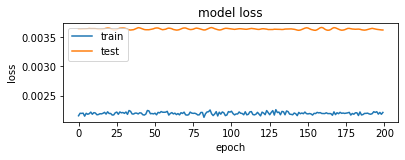

Prediction 124 of 244
dict_keys(['val_loss', 'loss'])


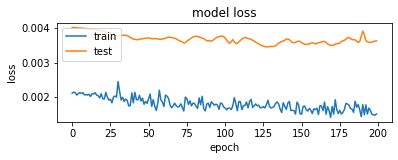

Prediction 125 of 244
dict_keys(['val_loss', 'loss'])


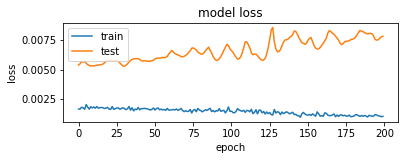

Prediction 126 of 244
dict_keys(['val_loss', 'loss'])


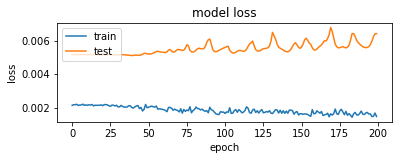

Prediction 127 of 244
dict_keys(['val_loss', 'loss'])


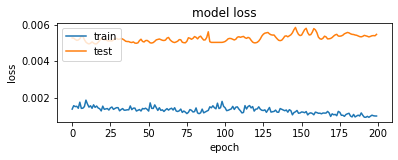

Prediction 128 of 244
dict_keys(['val_loss', 'loss'])


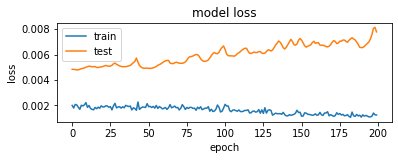

Prediction 129 of 244
dict_keys(['val_loss', 'loss'])


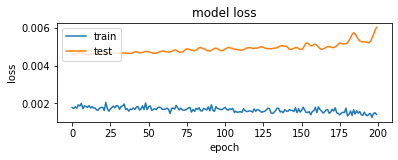

Prediction 130 of 244
dict_keys(['val_loss', 'loss'])


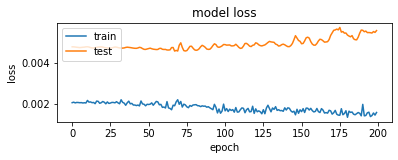

Prediction 131 of 244
dict_keys(['val_loss', 'loss'])


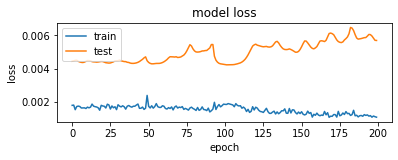

Prediction 132 of 244
dict_keys(['val_loss', 'loss'])


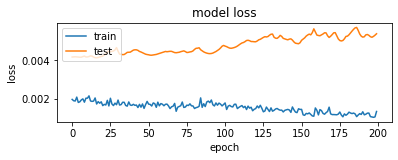

Prediction 133 of 244
dict_keys(['val_loss', 'loss'])


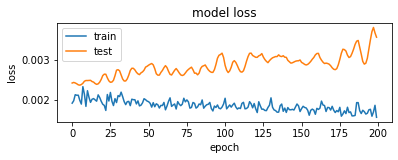

Prediction 134 of 244
dict_keys(['val_loss', 'loss'])


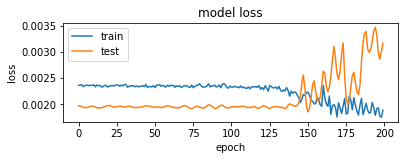

Prediction 135 of 244
dict_keys(['val_loss', 'loss'])


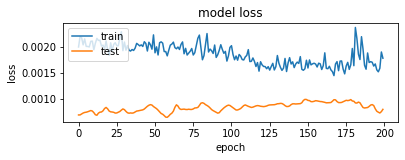

Prediction 136 of 244
dict_keys(['val_loss', 'loss'])


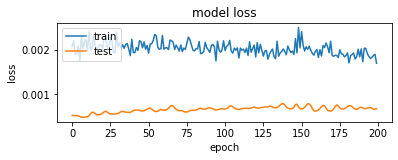

Prediction 137 of 244
dict_keys(['val_loss', 'loss'])


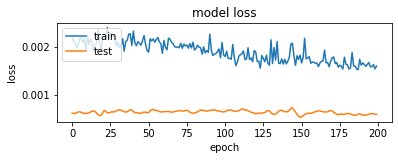

Prediction 138 of 244
dict_keys(['val_loss', 'loss'])


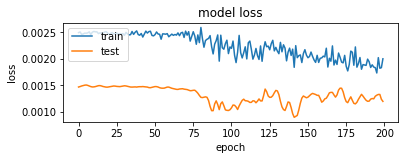

Prediction 139 of 244
dict_keys(['val_loss', 'loss'])


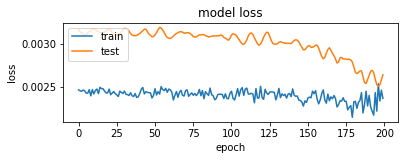

Prediction 140 of 244
dict_keys(['val_loss', 'loss'])


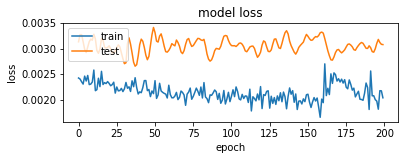

Prediction 141 of 244
dict_keys(['val_loss', 'loss'])


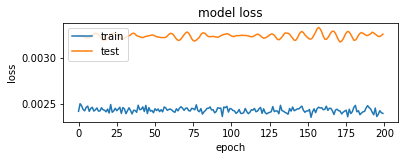

Prediction 142 of 244
dict_keys(['val_loss', 'loss'])


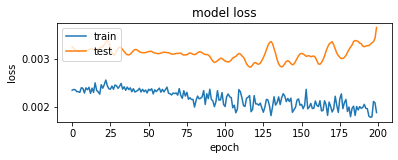

Prediction 143 of 244
dict_keys(['val_loss', 'loss'])


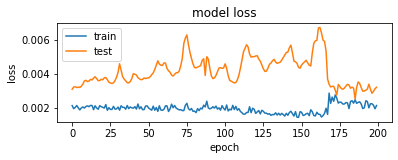

Prediction 144 of 244
dict_keys(['val_loss', 'loss'])


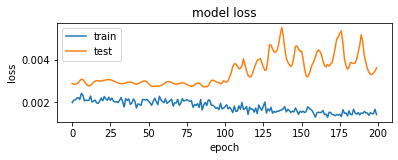

Prediction 145 of 244
dict_keys(['val_loss', 'loss'])


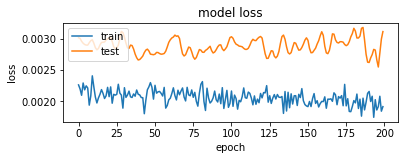

Prediction 146 of 244
dict_keys(['val_loss', 'loss'])


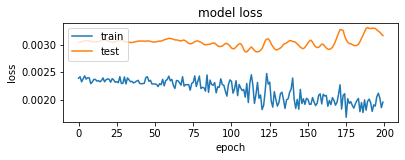

Prediction 147 of 244
dict_keys(['val_loss', 'loss'])


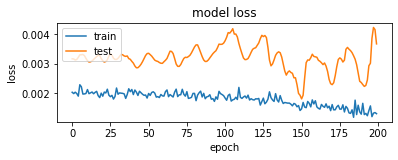

Prediction 148 of 244
dict_keys(['val_loss', 'loss'])


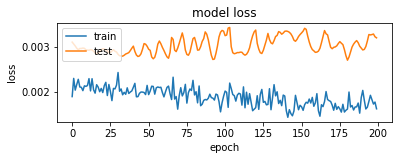

Prediction 149 of 244
dict_keys(['val_loss', 'loss'])


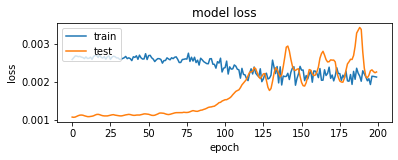

Prediction 150 of 244
dict_keys(['val_loss', 'loss'])


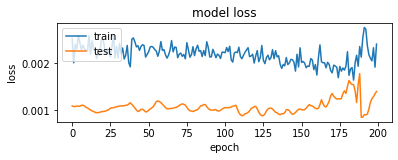

Prediction 151 of 244
dict_keys(['val_loss', 'loss'])


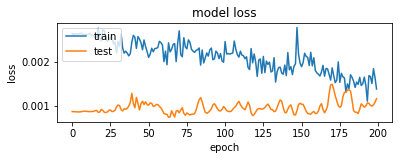

Prediction 152 of 244
dict_keys(['val_loss', 'loss'])


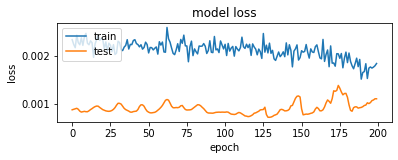

Prediction 153 of 244
dict_keys(['val_loss', 'loss'])


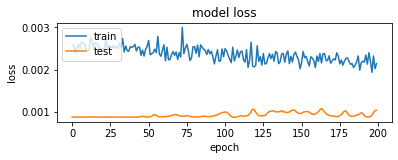

Prediction 154 of 244
dict_keys(['val_loss', 'loss'])


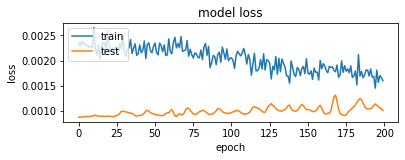

Prediction 155 of 244
dict_keys(['val_loss', 'loss'])


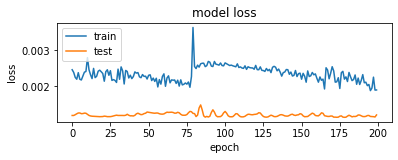

Prediction 156 of 244
dict_keys(['val_loss', 'loss'])


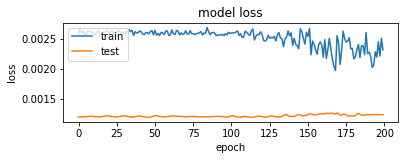

Prediction 157 of 244
dict_keys(['val_loss', 'loss'])


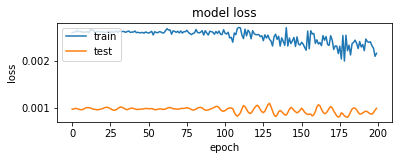

Prediction 158 of 244
dict_keys(['val_loss', 'loss'])


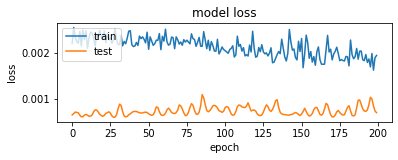

Prediction 159 of 244
dict_keys(['val_loss', 'loss'])


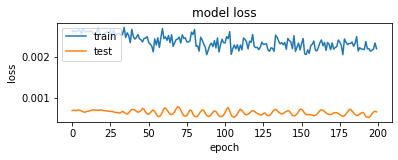

Prediction 160 of 244
dict_keys(['val_loss', 'loss'])


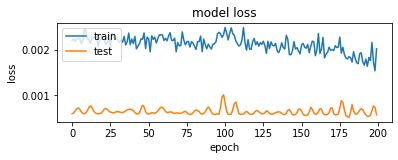

Prediction 161 of 244
dict_keys(['val_loss', 'loss'])


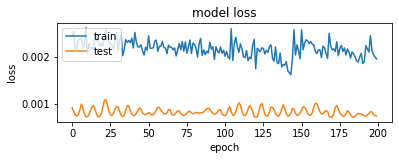

Prediction 162 of 244
dict_keys(['val_loss', 'loss'])


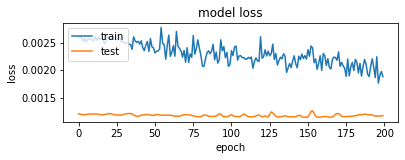

Prediction 163 of 244
dict_keys(['val_loss', 'loss'])


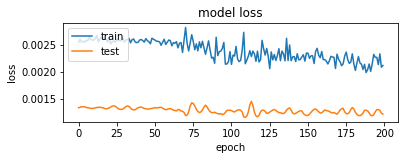

Prediction 164 of 244
dict_keys(['val_loss', 'loss'])


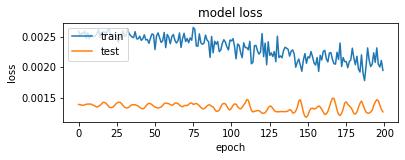

Prediction 165 of 244
dict_keys(['val_loss', 'loss'])


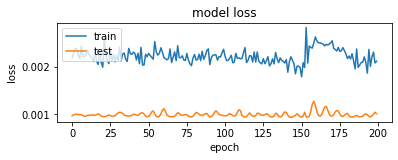

Prediction 166 of 244
dict_keys(['val_loss', 'loss'])


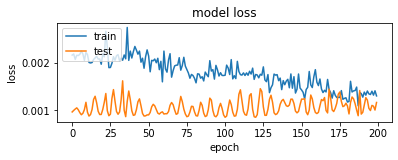

Prediction 167 of 244
dict_keys(['val_loss', 'loss'])


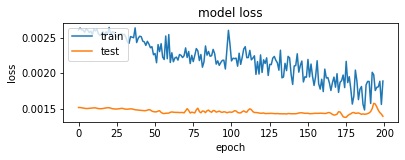

Prediction 168 of 244
dict_keys(['val_loss', 'loss'])


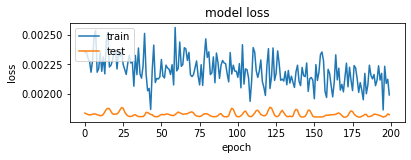

Prediction 169 of 244
dict_keys(['val_loss', 'loss'])


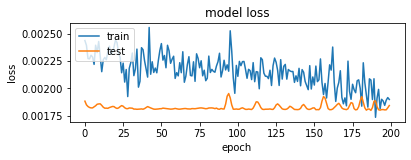

Prediction 170 of 244
dict_keys(['val_loss', 'loss'])


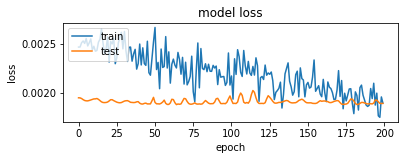

Prediction 171 of 244
dict_keys(['val_loss', 'loss'])


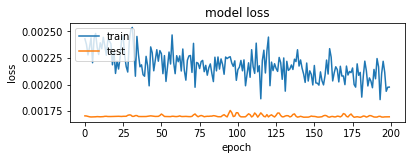

Prediction 172 of 244
dict_keys(['val_loss', 'loss'])


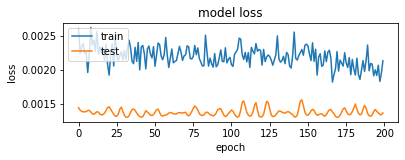

Prediction 173 of 244
dict_keys(['val_loss', 'loss'])


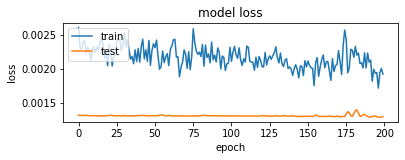

Prediction 174 of 244
dict_keys(['val_loss', 'loss'])


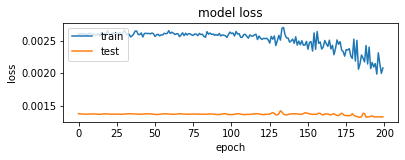

Prediction 175 of 244
dict_keys(['val_loss', 'loss'])


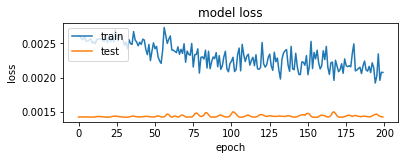

Prediction 176 of 244
dict_keys(['val_loss', 'loss'])


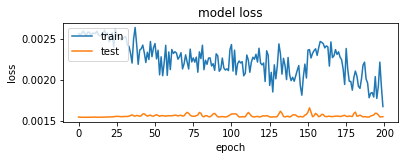

Prediction 177 of 244
dict_keys(['val_loss', 'loss'])


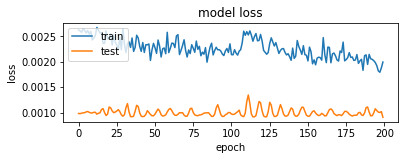

Prediction 178 of 244
dict_keys(['val_loss', 'loss'])


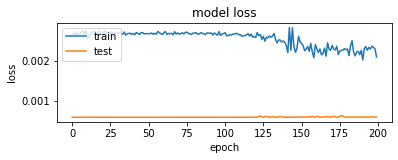

Prediction 179 of 244
dict_keys(['val_loss', 'loss'])


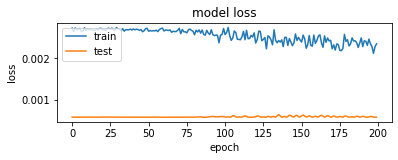

Prediction 180 of 244
dict_keys(['val_loss', 'loss'])


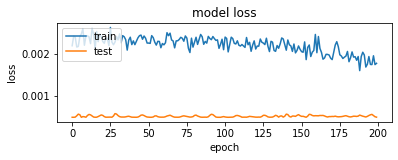

Prediction 181 of 244
dict_keys(['val_loss', 'loss'])


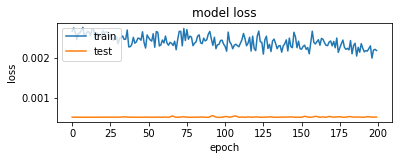

Prediction 182 of 244
dict_keys(['val_loss', 'loss'])


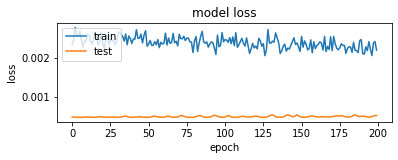

Prediction 183 of 244
dict_keys(['val_loss', 'loss'])


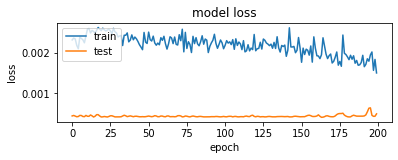

Prediction 184 of 244
dict_keys(['val_loss', 'loss'])


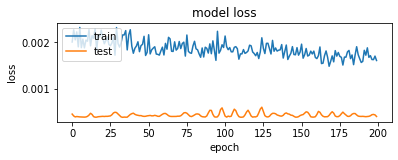

Prediction 185 of 244
dict_keys(['val_loss', 'loss'])


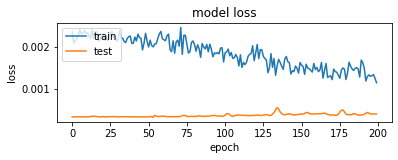

Prediction 186 of 244
dict_keys(['val_loss', 'loss'])


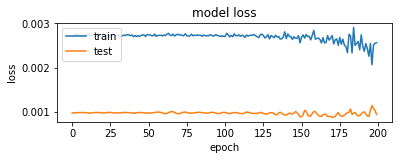

Prediction 187 of 244
dict_keys(['val_loss', 'loss'])


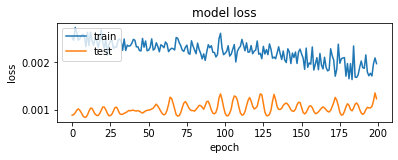

Prediction 188 of 244
dict_keys(['val_loss', 'loss'])


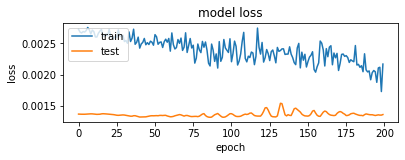

Prediction 189 of 244
dict_keys(['val_loss', 'loss'])


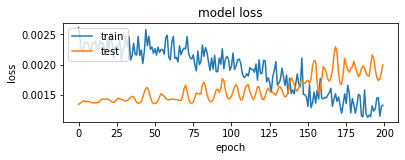

Prediction 190 of 244
dict_keys(['val_loss', 'loss'])


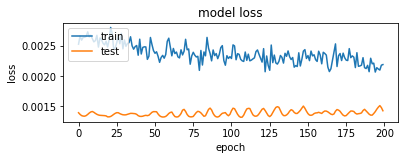

Prediction 191 of 244
dict_keys(['val_loss', 'loss'])


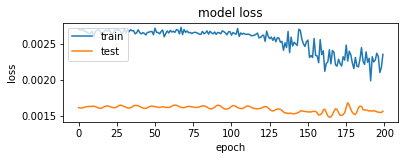

Prediction 192 of 244
dict_keys(['val_loss', 'loss'])


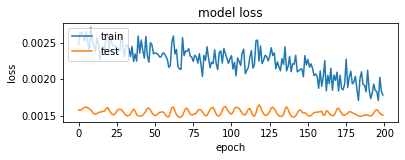

Prediction 193 of 244
dict_keys(['val_loss', 'loss'])


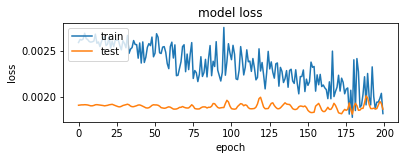

Prediction 194 of 244
dict_keys(['val_loss', 'loss'])


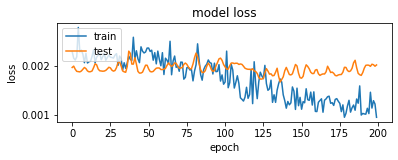

Prediction 195 of 244
dict_keys(['val_loss', 'loss'])


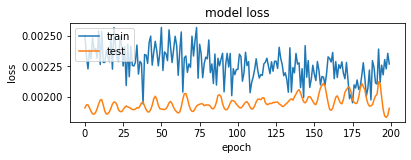

Prediction 196 of 244
dict_keys(['val_loss', 'loss'])


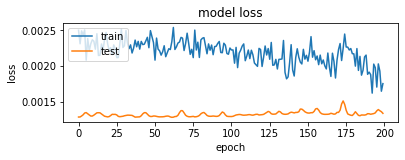

Prediction 197 of 244
dict_keys(['val_loss', 'loss'])


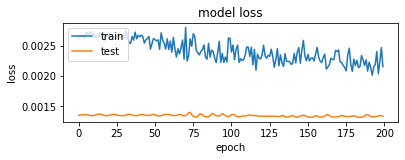

Prediction 198 of 244
dict_keys(['val_loss', 'loss'])


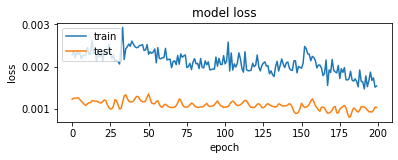

Prediction 199 of 244
dict_keys(['val_loss', 'loss'])


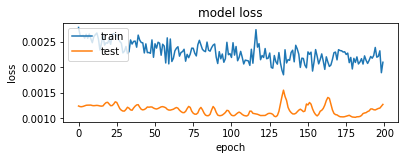

Prediction 200 of 244
dict_keys(['val_loss', 'loss'])


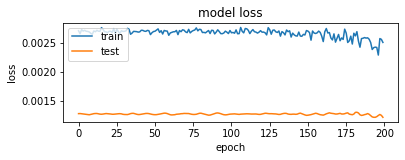

Prediction 201 of 244
dict_keys(['val_loss', 'loss'])


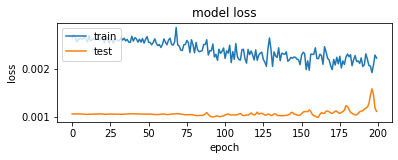

Prediction 202 of 244
dict_keys(['val_loss', 'loss'])


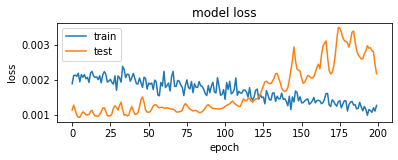

Prediction 203 of 244
dict_keys(['val_loss', 'loss'])


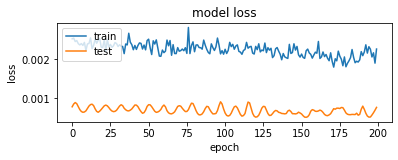

Prediction 204 of 244
dict_keys(['val_loss', 'loss'])


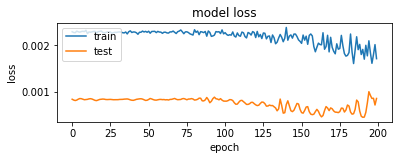

Prediction 205 of 244
dict_keys(['val_loss', 'loss'])


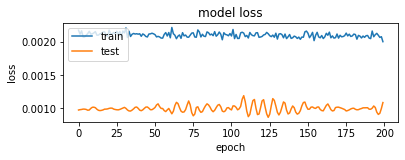

Prediction 206 of 244
dict_keys(['val_loss', 'loss'])


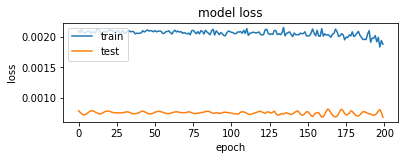

Prediction 207 of 244
dict_keys(['val_loss', 'loss'])


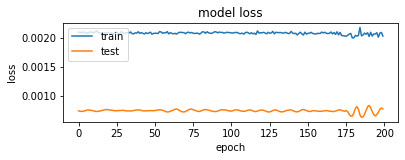

Prediction 208 of 244
dict_keys(['val_loss', 'loss'])


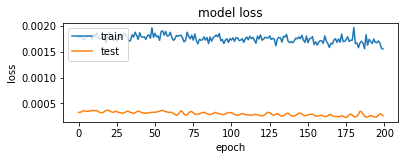

Prediction 209 of 244
dict_keys(['val_loss', 'loss'])


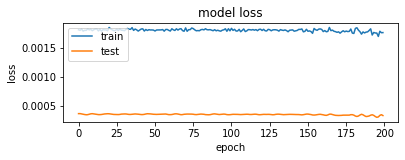

Prediction 210 of 244
dict_keys(['val_loss', 'loss'])


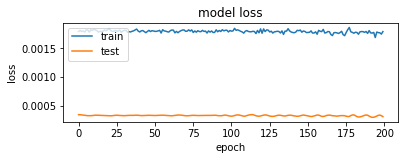

Prediction 211 of 244
dict_keys(['val_loss', 'loss'])


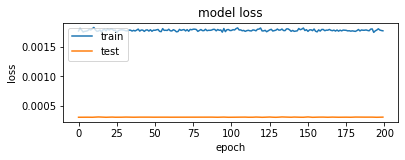

Prediction 212 of 244
dict_keys(['val_loss', 'loss'])


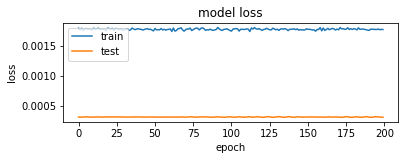

Prediction 213 of 244
dict_keys(['val_loss', 'loss'])


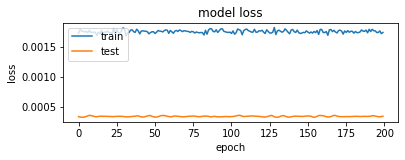

Prediction 214 of 244
dict_keys(['val_loss', 'loss'])


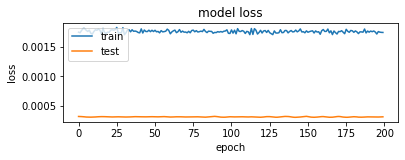

Prediction 215 of 244
dict_keys(['val_loss', 'loss'])


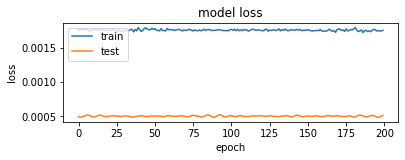

Prediction 216 of 244
dict_keys(['val_loss', 'loss'])


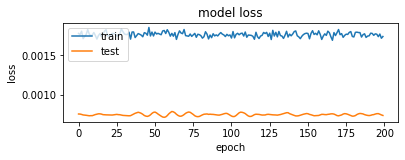

Prediction 217 of 244
dict_keys(['val_loss', 'loss'])


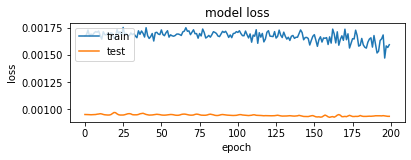

Prediction 218 of 244
dict_keys(['val_loss', 'loss'])


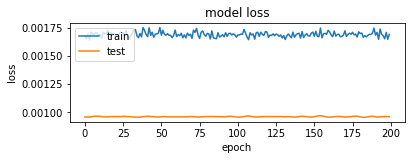

Prediction 219 of 244
dict_keys(['val_loss', 'loss'])


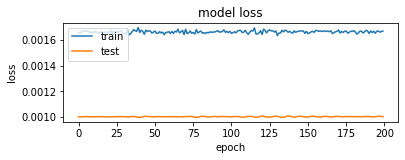

Prediction 220 of 244
dict_keys(['val_loss', 'loss'])


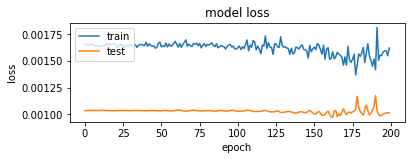

Prediction 221 of 244
dict_keys(['val_loss', 'loss'])


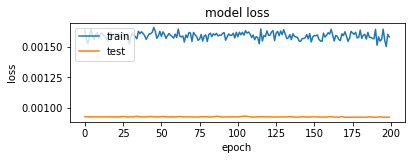

Prediction 222 of 244
dict_keys(['val_loss', 'loss'])


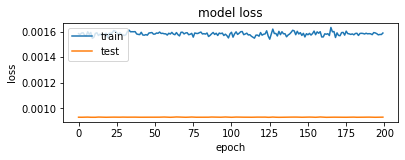

Prediction 223 of 244
dict_keys(['val_loss', 'loss'])


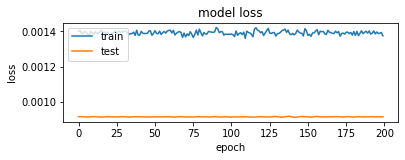

Prediction 224 of 244
dict_keys(['val_loss', 'loss'])


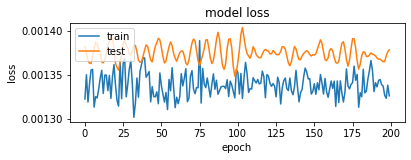

Prediction 225 of 244
dict_keys(['val_loss', 'loss'])


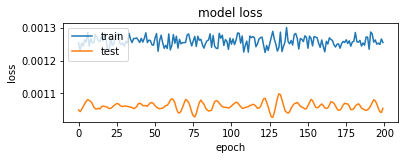

Prediction 226 of 244
dict_keys(['val_loss', 'loss'])


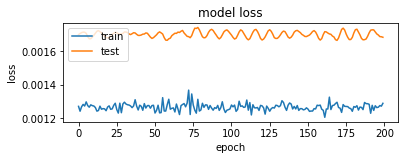

Prediction 227 of 244
dict_keys(['val_loss', 'loss'])


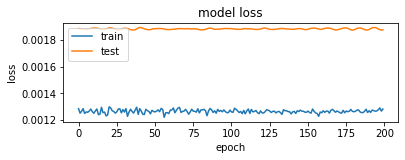

Prediction 228 of 244
dict_keys(['val_loss', 'loss'])


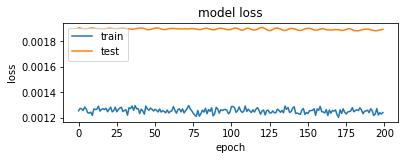

Prediction 229 of 244
dict_keys(['val_loss', 'loss'])


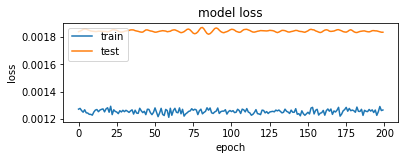

Prediction 230 of 244
dict_keys(['val_loss', 'loss'])


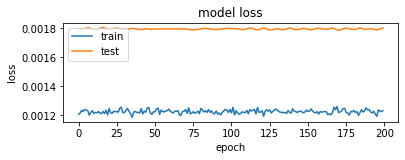

Prediction 231 of 244
dict_keys(['val_loss', 'loss'])


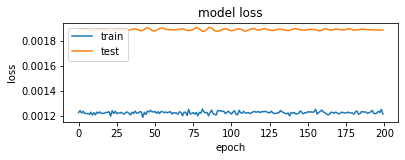

Prediction 232 of 244
dict_keys(['val_loss', 'loss'])


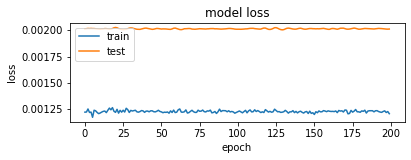

Prediction 233 of 244
dict_keys(['val_loss', 'loss'])


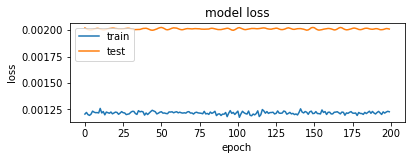

Prediction 234 of 244
dict_keys(['val_loss', 'loss'])


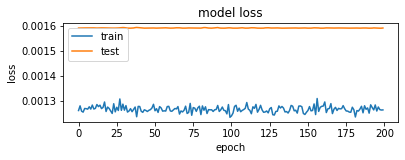

Prediction 235 of 244
dict_keys(['val_loss', 'loss'])


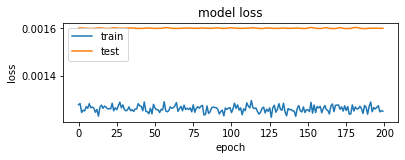

Prediction 236 of 244
dict_keys(['val_loss', 'loss'])


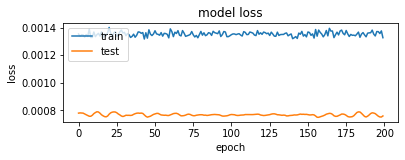

Prediction 237 of 244
dict_keys(['val_loss', 'loss'])


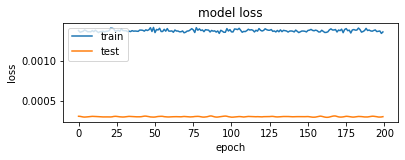

Prediction 238 of 244
dict_keys(['val_loss', 'loss'])


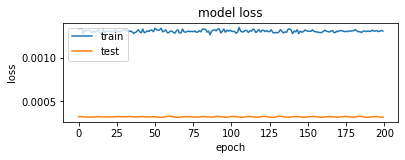

Prediction 239 of 244
dict_keys(['val_loss', 'loss'])


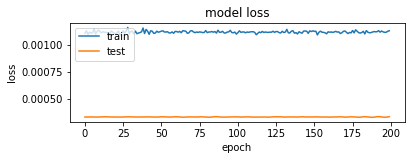

Prediction 240 of 244
dict_keys(['val_loss', 'loss'])


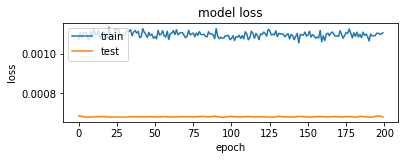

Prediction 241 of 244
dict_keys(['val_loss', 'loss'])


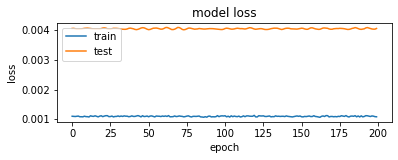

Prediction 242 of 244
dict_keys(['val_loss', 'loss'])


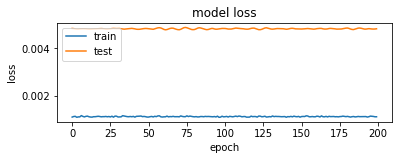

Prediction 243 of 244
dict_keys(['val_loss', 'loss'])


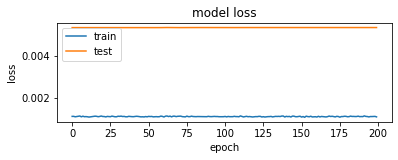

Prediction 244 of 244


In [13]:
pred_WO_LSTM = predictLSTM(W_WO_Xtrain, WOYtrain, W_WO_Xtest, WOYtest, W_WO_ForecastX)

In [14]:
LSTM_WO_Forecast = pd.DataFrame(pred_WO_LSTM)

In [15]:
LSTM_WO_Forecast.to_pickle('data/LSTM_WO_Forecast.pkl')

In [16]:
stop

NameError: name 'stop' is not defined